In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Liver
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Liver data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'TM_liver_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 14962.96it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,hepatocyte,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,xjw3n3^Tg},0.244374
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,hepatocyte,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,myeloid leukocyte,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,TnJke^X$c@,-0.254310
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,endothelial cell of hepatic sinusoid,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,endothelial cell of hepatic sinusoid,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990


## Dataset statistics

In [15]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'stats_age'] = 'Young'
    else:                        
        barcode.loc[j, 'stats_age'] = 'Old'

In [16]:
# Exploring cell counts
data = barcode[barcode['cell_type'].isin(['hepatocyte', 'Kupffer cell'])].value_counts(['cell_type', 'sex', 'stats_age', 'donor_id']).reset_index()
data.sort_values(by=['cell_type', 'sex', 'stats_age', 'donor_id'], 
                 ascending=[True, True, False, True], inplace=True)
data.reset_index(drop=True, inplace=True)
data.rename(columns={0: 'Counts'}, inplace=True)
data

,cell_type,sex,stats_age,donor_id,Counts
0,Kupffer cell,female,Old,18_46_F,76
1,Kupffer cell,male,Young,3_9_M,14
2,Kupffer cell,male,Young,3_11_M,33
3,Kupffer cell,male,Old,18_45_M,19
4,Kupffer cell,male,Old,18_53_M,12
5,Kupffer cell,male,Old,24_58_M,36
6,Kupffer cell,male,Old,24_59_M,72
7,hepatocyte,female,Young,3_56_F,82
8,hepatocyte,female,Young,3_57_F,79
9,hepatocyte,female,Old,18_46_F,63


In [17]:
# Function to extract cell counts
def datastats(cellpop):
    data2 = data[data.cell_type==cellpop]
    data2['Sex_age'] = data2['sex'].astype('str') + '_' + data2['stats_age'].astype('str')
    data2 = data2[['Sex_age', 'donor_id', 'Counts']]
    data2.sort_values(by=['Sex_age', 'donor_id', 'Counts'], ascending=[False, True, True],
                      inplace=True)
    custom_order = ['female_Young', 'female_Old', 'male_Young', 'male_Old']
    data2['Sex_age'] = pd.Categorical(data2['Sex_age'], categories=custom_order, ordered=True)

    data2 = data2.pivot_table(index='donor_id', columns='Sex_age', values='Counts', 
                              aggfunc='first')

    data2.reset_index(inplace=True)
    with pd.ExcelWriter(output_dir + "Cell_counts.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        data2.to_excel(writer, sheet_name=cellpop[:6]+'_smrtseq', index=True)

In [18]:
for i in ['hepatocyte', 'Kupffer cell']:
    datastats(cellpop=i)

## CMA net score/cell type (fold over whole tissue)

In [6]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,xjw3n3^Tg},0.244374,18-24m
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732,18-24m
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,TnJke^X$c@,-0.254310,18-24m
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050,18-24m
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990,18-24m


In [7]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,normal,Mus musculus,female,liver,na,18 month-old stage,xjw3n3^Tg},0.244374,18-24m,0.171704
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,normal,Mus musculus,male,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732,18-24m,-0.050938
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,normal,Mus musculus,female,liver,na,18 month-old stage,TnJke^X$c@,-0.254310,18-24m,-0.326980
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,normal,Mus musculus,female,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050,18-24m,-0.259719
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,normal,Mus musculus,male,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990,18-24m,0.303320


In [7]:
barcode.cell_type.unique()

['hepatocyte', 'myeloid leukocyte', 'endothelial cell of hepatic sinusoid', 'Kupffer cell', 'mature NK T cell', ..., 'natural killer cell', 'B cell', 'T cell', 'neutrophil', 'CD8-positive, alpha-beta T cell']
Length: 11
Categories (11, object): ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'Kupffer cell', ..., 'mature NK T cell', 'myeloid leukocyte', 'natural killer cell', 'neutrophil']

In [8]:
cells = ['hepatocyte', 'Kupffer cell']

## CMA net score/cell type & sex (fold over each cell type young)

In [9]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 11/11 [00:00<00:00, 65.97it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,Mus musculus,female,liver,na,18 month-old stage,xjw3n3^Tg},0.244374,18-24m,0.171704,0.157928
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,Mus musculus,male,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732,18-24m,-0.050938,-0.064713
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,Mus musculus,female,liver,na,18 month-old stage,TnJke^X$c@,-0.254310,18-24m,-0.326980,-0.248610
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,Mus musculus,female,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050,18-24m,-0.259719,-0.326713
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,Mus musculus,male,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990,18-24m,0.303320,0.236326


### Graphs

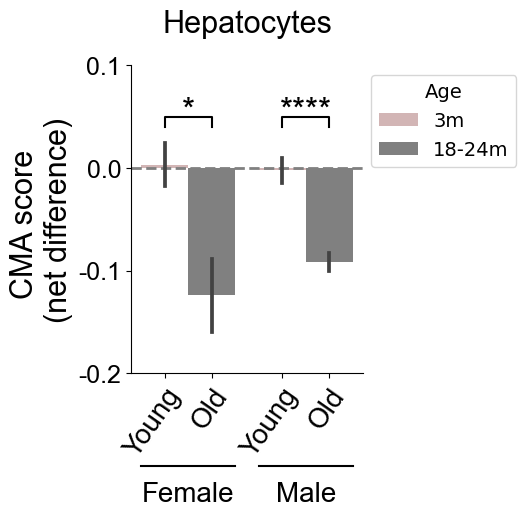

In [10]:
# Figure Hepatocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.10)
ax.set_yticks([-0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.04 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x3, x4 = 0.8, 1.2   
y2, h, col = 0.04 , 0.01, 'k'
plt.plot([x3, x3, x4, x4], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x3+x4)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Hepat_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

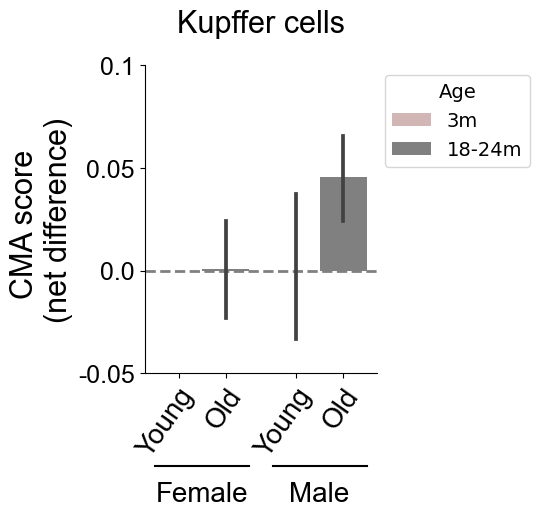

In [11]:
# Figure Kupffer cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.05, 0.10)
ax.set_yticks([-0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Kupf_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [12]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Livsmart_Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
    
    return(df_raw)

In [13]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,hepatocyte,3m,female,161,2.955024e-03,0.021098
1,hepatocyte,3m,male,240,-1.982328e-03,0.012421
2,hepatocyte,18-24m,female,63,-1.235105e-01,0.036263
3,hepatocyte,18-24m,male,698,-9.188788e-02,0.009053
4,Kupffer cell,3m,female,0,NaN,NaN
5,Kupffer cell,3m,male,47,-8.119982e-18,0.037273
6,Kupffer cell,18-24m,female,76,5.599415e-04,0.024561
7,Kupffer cell,18-24m,male,139,4.569554e-02,0.021506


## CMA network heatmaps by cell type & sex

In [14]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [15]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Livsmart_Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop+'_heat', index=True)
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmax=1.5, vmin=-1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + '/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 28.07it/s]


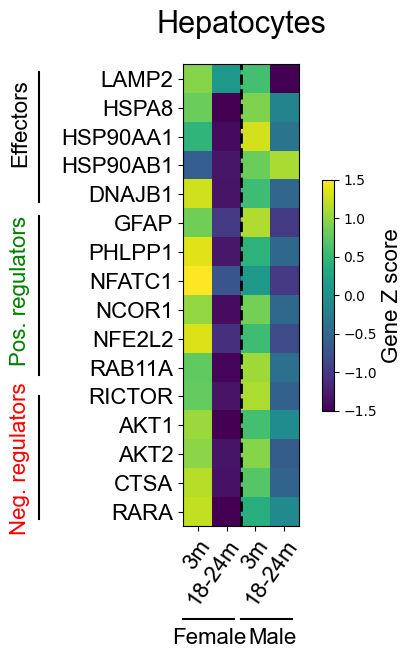

In [16]:
sex_heatmaps(cellpop='hepatocyte')

In [17]:
# There are no female 3m kuppfer cells so we adjust the previous function
def sex_kupp(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 3))
    
    #Find cell indices for each condition
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Livsmart_Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop+'_heat', index=True)
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmax=1.5, vmin=-1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(3), ['18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=0.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-2, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.65,-1.65],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Pos. regulators', xy=(-2, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.65,-1.65],[4.75, 10.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Neg. regulators', xy=(-2, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.65,-1.65],[11, 15.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Female', xy=(-0.5, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.25,0.5],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('Male', xy=(1.75, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1, 2.5],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + '/Kupf_heat.png',bbox_inches='tight', dpi=300)

    plt.show()

100%|██████████| 16/16 [00:00<00:00, 64.56it/s]


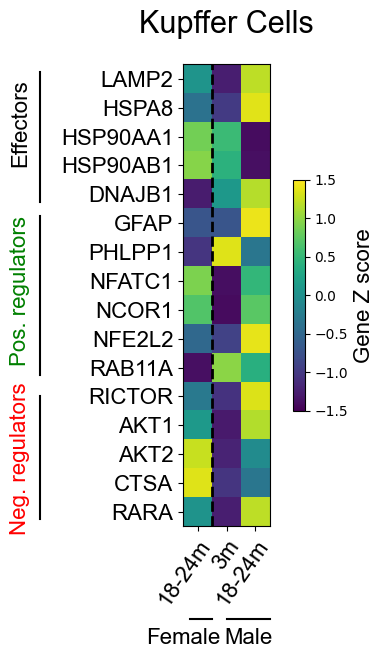

In [18]:
sex_kupp(cellpop='Kupffer cell')

# Lysosomal genes

In [13]:
# Reading table with genes
genes = pd.read_excel(modelmx, 'Review_genes') 

In [15]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
notfound = ['ENSMUSG00000035953', 'ENSMUSG00000038295', 'ENSMUSG00000006056', 
            'ENSMUSG00000029104', 'ENSMUSG00000050697', 'ENSMUSG00000028518', 
            'ENSMUSG00000032127', 'ENSMUSG00000053647']


idx_val = genes.loc[genes['Ensembl Ms'].isin(notfound)].index.tolist()

# Removing genes not present
model_matrix = genes.drop(idx_val, axis=0).reset_index(drop=True)

# Finding genes of interest in the dataset
network = adata[:, model_matrix['Ensembl Ms']]

In [16]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(model_matrix['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# Reset obs index
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

### Lysosome physiology genes

In [17]:
genes = model_matrix[model_matrix['Gene_set']=='Lysosomes']['Symbol'].to_list()
print(genes[:4])
len(genes)

['ASAH1', 'CTSA', 'CTSB', 'CTSD']


54

In [26]:
def lysosomes(cellpop):
    
    # Prepare empty matrix
    if cellpop == 'hepatocyte':
        matrix = np.zeros((54, 4))
    else:
        matrix = np.zeros((54, 3))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    if cellpop == 'hepatocyte':
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    else:
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_18_24m, rank].X.todense())
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    if cellpop == 'hepatocyte':
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_young', 'female_old', 'male_young', 'male_old'],
                            index=genes)
    else:
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_old', 'male_young', 'male_old'],
                            index=genes)
        
    df_m.to_excel(output_dir + "Livsmt{}_raw.xlsx".format(cellpop[:3]), 
                  sheet_name='Lysosomes', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,14))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(54), genes, fontsize=16, **hfont)

    plt.ylim(53.5, -0.5)

    if cellpop == 'hepatocyte':
        plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
    else:
        plt.xticks(np.arange(3), ['Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
        
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    if cellpop == 'hepatocyte':
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
    else:
        plt.axvline(x=0.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
        
    if cellpop == 'hepatocyte':
        ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    else:
        ax.annotate('F', xy=(0, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,0.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(1.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([0.5, 2.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'livsmt{}lysheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 54/54 [00:01<00:00, 46.74it/s]


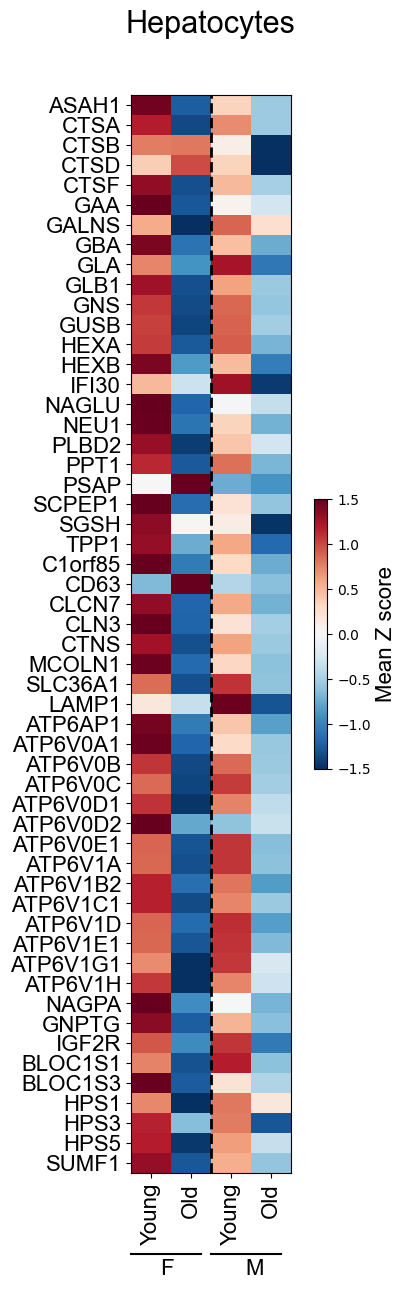

100%|██████████| 54/54 [00:00<00:00, 71.91it/s]


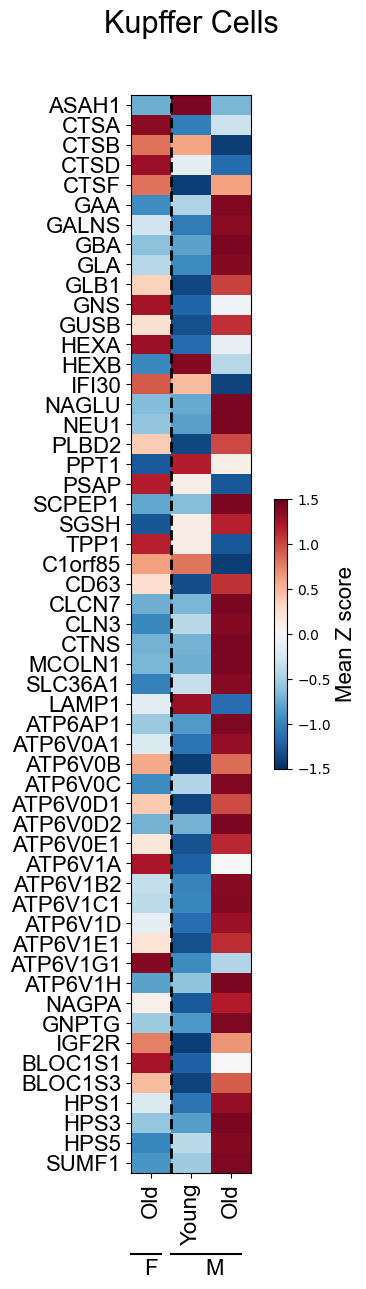

In [27]:
for i in cells:
    lysosomes(cellpop=i)

### Macroautophagy genes

In [28]:
genes = model_matrix[model_matrix['Gene_set']=='Macroautophagy']['Symbol'].to_list()
print(genes[:4])
len(genes)

['AMBRA1', 'ATG3', 'ATG4A', 'ATG4B']


77

In [29]:
def macro(cellpop):
    
    # Prepare empty matrix
    if cellpop == 'hepatocyte':
        matrix = np.zeros((77, 4))
    else:
        matrix = np.zeros((77, 3))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    if cellpop == 'hepatocyte':
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    else:
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_18_24m, rank].X.todense())
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    if cellpop == 'hepatocyte':
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_young', 'female_old', 'male_young', 'male_old'],
                            index=genes)
    else:
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_old', 'male_young', 'male_old'],
                            index=genes)
        
    with pd.ExcelWriter(output_dir + "Livsmt{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Macroautophagy', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,18))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(77), genes, fontsize=16, **hfont)

    plt.ylim(76.5, -0.5)

    if cellpop == 'hepatocyte':
        plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
    else:
        plt.xticks(np.arange(3), ['Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
        
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    if cellpop == 'hepatocyte':
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
    else:
        plt.axvline(x=0.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
        
    if cellpop == 'hepatocyte':
        ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    else:
        ax.annotate('F', xy=(0, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,0.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(1.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([0.5, 2.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'livsmt{}MAheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 77/77 [00:01<00:00, 47.73it/s]


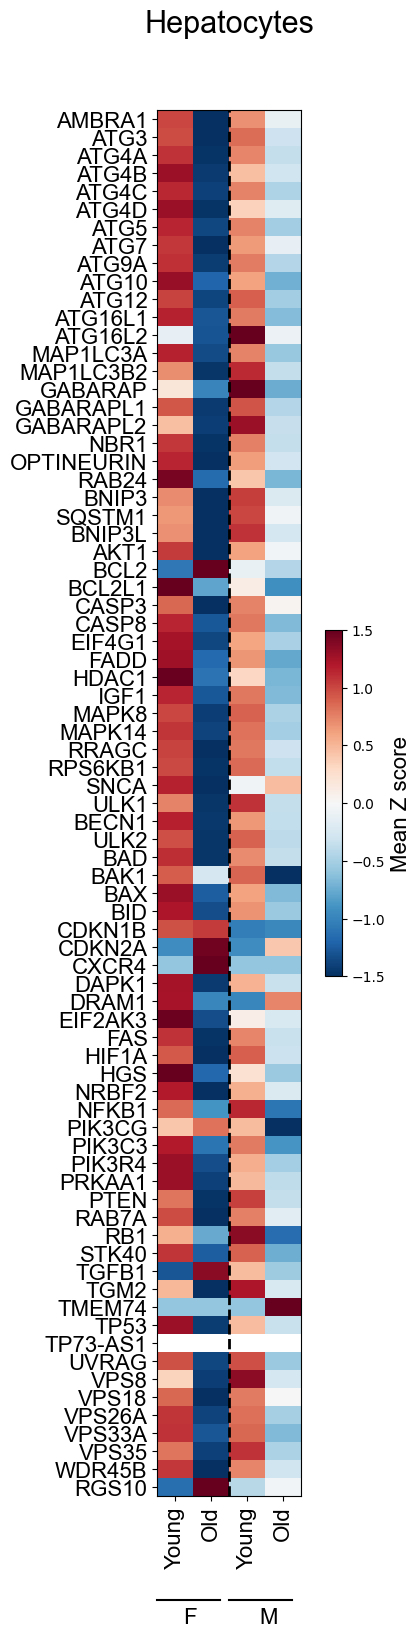

100%|██████████| 77/77 [00:01<00:00, 72.17it/s]


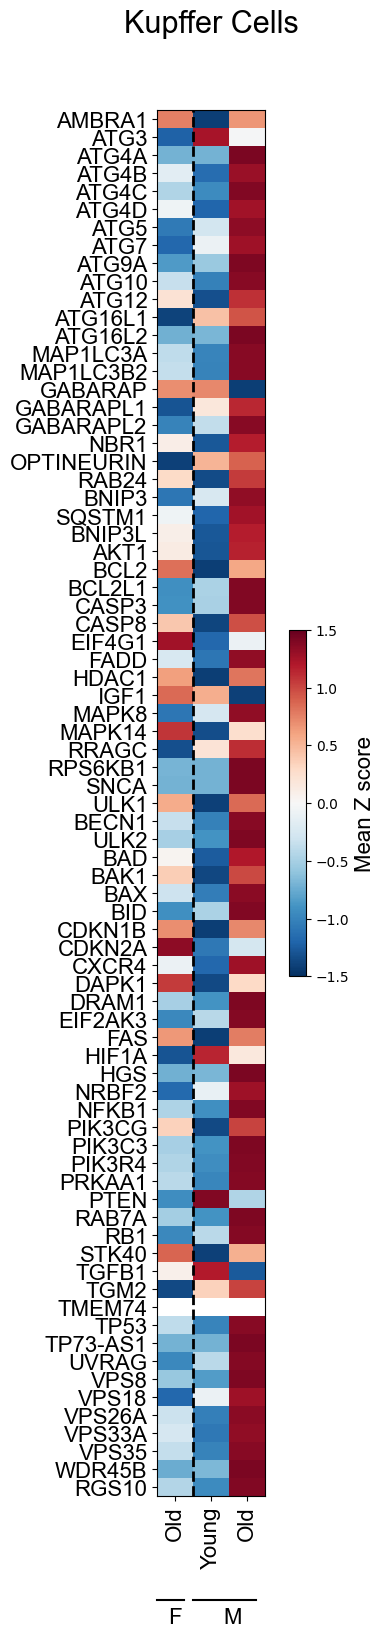

In [30]:
for i in cells:
    macro(cellpop=i)

### Selective MA

In [31]:
genes = model_matrix[model_matrix['Gene_set']=='Selective MA']['Symbol'].to_list()
print(genes[:4])
len(genes)

['Bcl2L13', 'PHB2', 'TAX1BP1', 'PINK']


15

In [32]:
def selective(cellpop):
    
    # Prepare empty matrix
    if cellpop == 'hepatocyte':
        matrix = np.zeros((15, 4))
    else:
        matrix = np.zeros((15, 3))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    if cellpop == 'hepatocyte':
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    else:
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_18_24m, rank].X.todense())
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    if cellpop == 'hepatocyte':
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_young', 'female_old', 'male_young', 'male_old'],
                            index=genes)
    else:
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_old', 'male_young', 'male_old'],
                            index=genes)
        
    with pd.ExcelWriter(output_dir + "Livsmt{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Selective MA', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3, 9))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(15), genes, fontsize=16, **hfont)

    plt.ylim(14.5, -0.5)

    if cellpop == 'hepatocyte':
        plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
    else:
        plt.xticks(np.arange(3), ['Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
        
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    if cellpop == 'hepatocyte':
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
    else:
        plt.axvline(x=0.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
        
    if cellpop == 'hepatocyte':
        ax.annotate('F', xy=(0.4, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(2.6, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    else:
        ax.annotate('F', xy=(0, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,0.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(1.6, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([0.5, 2.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'livsmt{}selMAheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 15/15 [00:00<00:00, 47.80it/s]


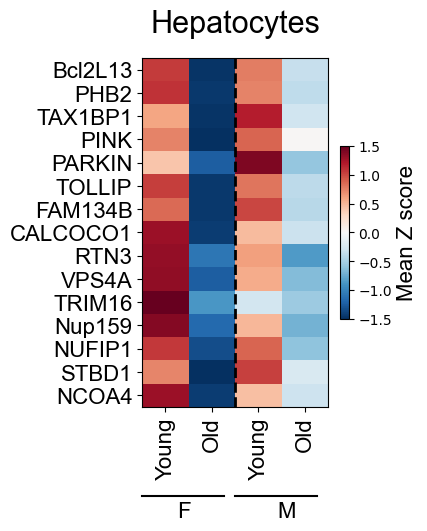

100%|██████████| 15/15 [00:00<00:00, 72.80it/s]


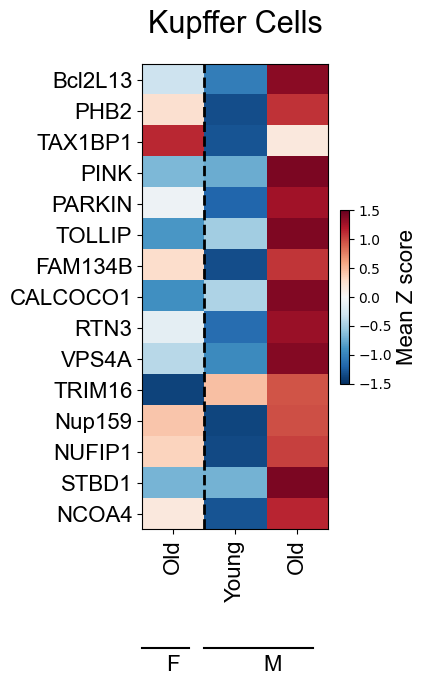

In [33]:
for i in cells:
    selective(cellpop=i)

### Extra lysosomal genes

In [6]:
# Reading table with genes
modelmx = pd.read_excel(modelmx, 'LysExtra') 
genes = list(modelmx['Symbol'])

In [7]:
# Finding genes of interest in the dataset
network = adata[:, modelmx['Ensembl Ms']]
network.var_names

Index(['ENSMUSG00000023990', 'ENSMUSG00000000134', 'ENSMUSG00000029553'], dtype='object')

In [8]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(modelmx['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# reset obs index
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

In [37]:
def selective(cellpop):
    
    # Prepare empty matrix
    if cellpop == 'hepatocyte':
        matrix = np.zeros((3, 4))
    else:
        matrix = np.zeros((3, 3))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
        
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    if cellpop == 'hepatocyte':
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    else:
        for rank in tqdm(np.arange(matrix.shape[0])):    
            matrix[rank, 0] = np.mean(genedf[female_18_24m, rank].X.todense())
            matrix[rank, 1] = np.mean(genedf[male_3m, rank].X.todense())
            matrix[rank, 2] = np.mean(genedf[male_18_24m, rank].X.todense())
     
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    if cellpop == 'hepatocyte':
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_young', 'female_old', 'male_young', 'male_old'],
                            index=genes)
    else:
        df_m = pd.DataFrame(matrix_zs, 
                            columns=['female_old', 'male_young', 'male_old'],
                            index=genes)
        
    with pd.ExcelWriter(output_dir + "Livsmt{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='LysExtra', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,5))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(3), genes, fontsize=16, **hfont)

    plt.ylim(2.5, -0.5)

    if cellpop == 'hepatocyte':
        plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
    else:
        plt.xticks(np.arange(3), ['Old', 'Young', 'Old'], 
                rotation=90, fontsize=16, **hfont)
        
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    if cellpop == 'hepatocyte':
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
    else:
        plt.axvline(x=0.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    if cellpop == 'hepatocyte':
        ax.annotate('F', xy=(0.4, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.3,1.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(2.6, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.7, 3.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    else:
        ax.annotate('F', xy=(-0.05, -1.05), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.3,0.3],[-0.95,-0.95], color="k", transform=trans2, clip_on=False)
        ax.annotate('M', xy=(1.5, -1.05), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([0.75, 2.25],[-0.95,-0.95], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'livsmt{}lysextraheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 3/3 [00:00<00:00, 49.98it/s]


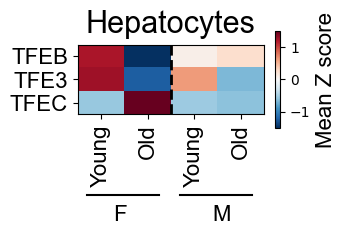

100%|██████████| 3/3 [00:00<00:00, 53.69it/s]


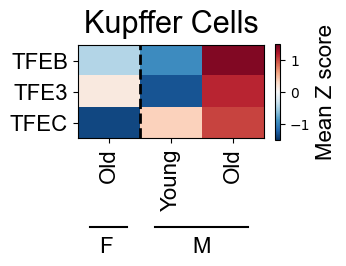

In [38]:
for i in cells:
    selective(cellpop=i)

## Macro score

In [35]:
# Load matrix file with weight and direction 
mamx = pd.read_excel(modelmx, 'Macroautophagy')

# Removing genes not present in the adata
not_found = ['ENSMUSG00000038295', 'ENSMUSG00000006056', 'ENSMUSG00000029104', 
             'ENSMUSG00000050697', 'ENSMUSG00000028518', 'ENSMUSG00000032127']
mamx = mamx.drop(mamx[mamx["Ensembl Ms"].isin(not_found)].index, axis=0).reset_index(drop=True)

# Finding MA network genes in the dataset
ma_network = adata[:, mamx["Ensembl Ms"]]

In [38]:
# Calculating the Zs scores
ma_data_zs = ma_network.copy().X.todense().T

for i in tqdm(np.arange(ma_data_zs.shape[0])):
    
    µ = np.mean(ma_data_zs[i, :])
    sd = np.std(ma_data_zs[i, :])
    
    ma_data_zs[i, :] = (ma_data_zs[i, :] - µ)/sd

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = mamx.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = ma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['direction'] * cell_matrix['weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['weight'])

    barcode.loc[j, 'ma_score'] = score   

barcode.head()
    

100%|██████████| 78/78 [00:00<00:00, 19007.42it/s]
2859it [00:08, 323.05it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,ma_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,female,liver,na,18 month-old stage,xjw3n3^Tg},0.244374,18-24m,0.171704,0.157928,-0.196976
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,male,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732,18-24m,-0.050938,-0.064713,-0.137930
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,female,liver,na,18 month-old stage,TnJke^X$c@,-0.254310,18-24m,-0.326980,-0.248610,-0.030095
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,female,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050,18-24m,-0.259719,-0.326713,-0.282466
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,male,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990,18-24m,0.303320,0.236326,0.119496


In [39]:
# Calculation of ma net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '3m']['ma_score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'macell_ns'] = barcode.loc[cell_index, 'ma_score'] - µ  

barcode.head()

100%|██████████| 11/11 [00:00<00:00, 63.16it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,ma_score,macell_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,liver,na,18 month-old stage,xjw3n3^Tg},0.244374,18-24m,0.171704,0.157928,-0.196976,-0.485151
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732,18-24m,-0.050938,-0.064713,-0.137930,-0.426106
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,liver,na,18 month-old stage,TnJke^X$c@,-0.254310,18-24m,-0.326980,-0.248610,-0.030095,-0.082306
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050,18-24m,-0.259719,-0.326713,-0.282466,-0.221309
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990,18-24m,0.303320,0.236326,0.119496,0.180653


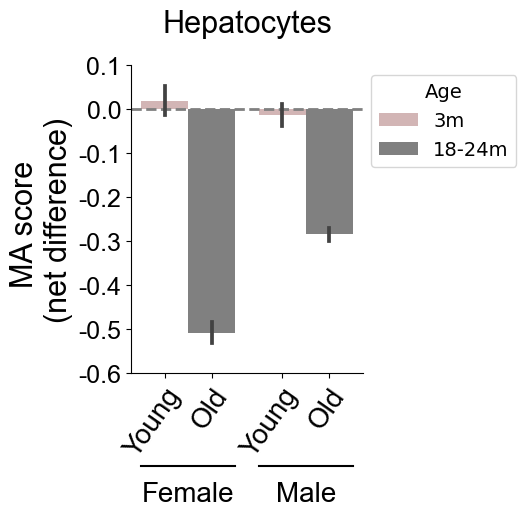

In [45]:
# Figure Hepatocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.60, 0.10)
ax.set_yticks([-.6, -.5, -.4, -.3, -0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-.6, -.5, -.4, -.3, -0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + 'livsmthepmans.png',bbox_inches='tight', dpi=600)

plt.show()

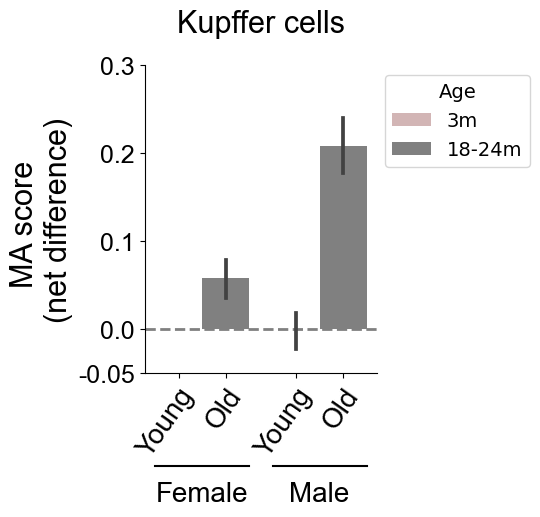

In [50]:
# Figure Kupffer cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.05, 0.30)
ax.set_yticks([-0.05, 0.00, 0.10, .2, .3])
ax.set_yticklabels([-0.05, 0.00, 0.10, .2, .3], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + 'livsmtkupmans.png',bbox_inches='tight', dpi=600)

plt.show()

In [52]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad=['3m', '18-24m'], sex=['female', 'male']):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for x in edad:
        for y in sex:
            n = len(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y].index)
            m = np.mean(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])
            s = stats.sem(barcode[barcode['cell_type']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])

            long.append(n)
            celula.append(tipos)                
            age.append(x)
            sexo.append(y)
            mean.append(m)
            sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter(output_dir + "Livsmt{}_raw.xlsx".format(tipos[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_raw.to_excel(writer, sheet_name='MA score', index=True)

    print(df_raw)

In [53]:
for i in cells:
    raw(tipos = i)

    Cell_type     Age     Sex    n      Mean       SEM
0  hepatocyte      3m  female  161  0.018602  0.035577
1  hepatocyte      3m    male  240 -0.012479  0.025243
2  hepatocyte  18-24m  female   63 -0.509396  0.023716
3  hepatocyte  18-24m    male  698 -0.284210  0.015002
      Cell_type     Age     Sex    n          Mean       SEM
0  Kupffer cell      3m  female    0           NaN       NaN
1  Kupffer cell      3m    male   47  2.952721e-18  0.021044
2  Kupffer cell  18-24m  female   76  5.795777e-02  0.021969
3  Kupffer cell  18-24m    male  139  2.077414e-01  0.031970


## XIST data

In [11]:
# Reading df for hormone receptors
horm = pd.read_excel(modelmx, 'Review_genes')
horm_symbol = horm[horm['Symbol']=='XIST']['Symbol'].to_list()
horm_ensembl = horm[horm['Symbol']=='XIST']['Ensembl Ms'].to_list()

In [12]:
# Finding genes of interest in the dataset
hormdf = adata[:, horm_ensembl]
hormdf.layers["scaled"] = sc.pp.scale(hormdf, copy=True).X
hormdf

AnnData object with n_obs × n_vars = 2859 × 1
    obs: 'FACS.selection', 'age', 'cell', 'free_annotation', 'method', 'donor_id', 'subtissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'age_colors', 'citation', 'leiden', 'louvain', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'

In [13]:
# Dataframe with Xist Zs values
hormzs = pd.DataFrame(hormdf.layers['scaled'], columns = horm_symbol, index=hormdf.obs.index)
hormzs.head()

,XIST
index,
A10_B000767_B009945_S10.mm10-plus-4-0,-0.328124
A10_D045313_B009942_S10.mm10-plus-4-0,-0.328124
A11_B000767_B009945_S11.mm10-plus-4-0,2.626469
A11_B001247_B009941_S11.mm10-plus-4-0,-0.328124
A11_B002688_B009944_S11.mm10-plus-4-0,-0.328124


In [14]:
# Merging Barcode and Hormonze Z values dataframe
barcode = pd.merge(barcode, hormzs, how='inner', on='index')
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns,XIST
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075195,7,...,female,liver,na,18 month-old stage,xjw3n3^Tg},0.244374,18-24m,0.171704,0.157928,-0.328124
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,male,liver,na,18 month-old stage,pZ?^*OT>{5,0.021732,18-24m,-0.050938,-0.064713,-0.328124
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733398,3,...,female,liver,na,18 month-old stage,TnJke^X$c@,-0.254310,18-24m,-0.326980,-0.248610,2.626469
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741699,13,...,female,liver,na,18 month-old stage,`y0EWT|jXT,-0.187050,18-24m,-0.259719,-0.326713,-0.328124
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,male,liver,na,18 month-old stage,{Wx)DIHeI;,0.375990,18-24m,0.303320,0.236326,-0.328124


In [17]:
def hormones (cellpop, horm='XIST'):

    print('Working on {}'.format(cellpop))

    # Dataframe for non-zero hormone values
    filt = barcode[barcode.cell_type==cellpop]
    filt = filt[filt[horm] > np.min(filt[horm])]             

    # Saving raw data
    df = filt[['new_cell', 'sex', 'new_age', 'celltype_ns', horm]]
    with pd.ExcelWriter(output_dir + "Livsmt{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df.to_excel(writer, sheet_name='{}_corr'.format(horm), index=True)
        
    # Figure regression for female old
    filtered_data = filt[(filt['sex'] == 'female') & (filt['new_age'] == '18-24m')]
    plt.figure(figsize=(8, 6))
    plot = sns.scatterplot(data=filtered_data, x=horm, y='celltype_ns', hue='new_age', 
                    palette=['#808080'], s=50, edgecolor='black', alpha=0.7)

    plt.xlabel("Xist expression", fontsize=14)
    plt.ylabel("CMA transcriptional score", fontsize=14)

    # Ajustar los parámetros de los ejes
    plot.tick_params(axis='x', labelsize=12)
    plot.tick_params(axis='y', labelsize=12)
    plt.legend(title="Age", title_fontsize="14", fontsize=12)
    
    plt.savefig(output_dir + 'livsmt{}{}.png'.format(cellpop[:3], horm),bbox_inches='tight', dpi=600)

    plt.show()

    # Figure bars
    plt.figure(figsize=(3, 5))
    ax = sns.barplot(data=filt, x='sex', y=horm, hue='new_age', order=['female'], 
                     hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)

    sns.stripplot(data=filt, x='sex', y=horm, palette=['white'], dodge=True, hue='new_age',
                  hue_order=['3m', "18-24m"], s=6.5, edgecolor='k', linewidth=1, alpha=0.7, legend=False)

    plt.xlabel('')
    plt.ylabel('Xist expression', fontdict={'family':'Arial', 'size': 20})
    plt.xticks(ticks=[0], labels=['Females'], fontdict={'family':'Arial', 'size': 14}) 
    plt.title(label=cellpop, fontdict={'family':'Arial', 'size': 20}, y=1.08)
    
    plt.savefig(output_dir + 'Xist{}_age.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()
        


Working on hepatocyte


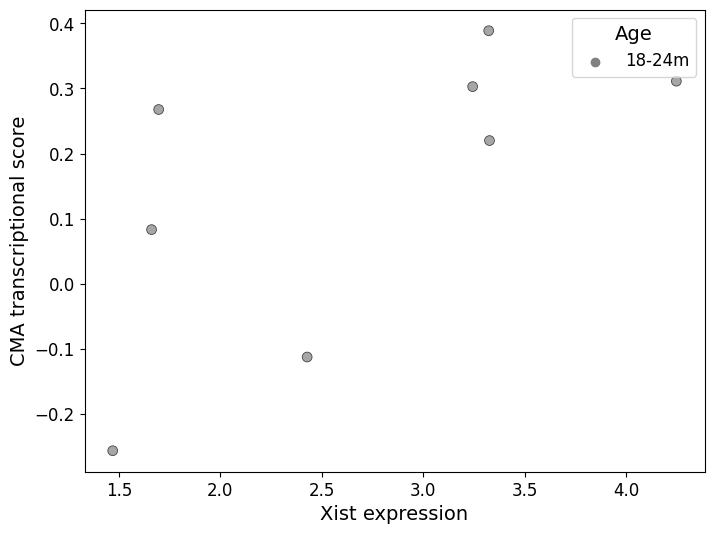

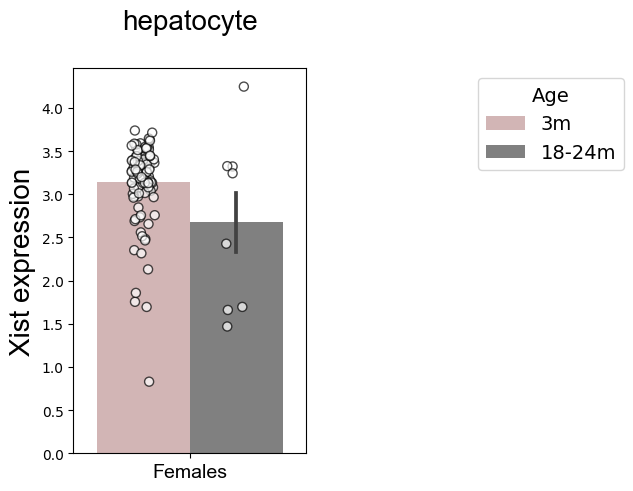

Working on Kupffer cell


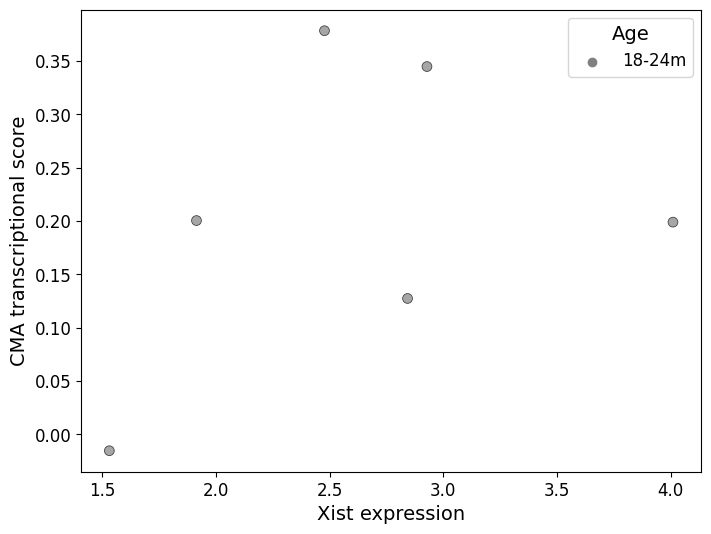

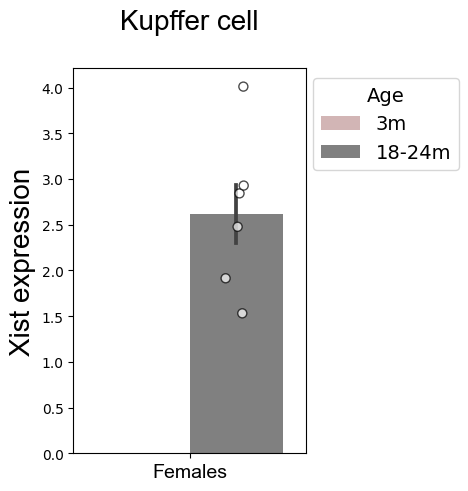

In [18]:
for i in cells:
    hormones(cellpop=i)